In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import pylab as plt

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

# Chapter 9 - MARKOV CHAIN MONTE CARLO

Lets dive straight into the end of chapter problems on this one. Hopefully this chapter will illuminate some of the dramatic looking warning messages that pymc3 throws at you when sampling. But they should be helpful

9E1. Which of the following is a requirement of the simple Metropolis algorithm?

(1) The parameters must be discrete.

(2) The likelihood function must be Gaussian.

(3) The proposal distribution must be symmetric

Answer: 3), The propposal distribution must be symmetric.

9E2. Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra
efficiency? Are there any limitations to the Gibbs sampling strategy?

Answer: Adaptive proposals. Gibbs samplers can make dynamically modify the distribution of the next place it will explore in the distribution based on the models current location in parameter space.

9E3. Which sort of parameters can Hamiltonian Monte Carlo not handle? Can you explain why?

Answer: It relies on doing classical mechanics style simulations. The important thing is that the particle should be able to stop at any point, which it can't in a discrete phases space.

Conventionally Hamiltonians often have derivatives of their degrees of freedom (referred to as conjugate momenta). I presume there's some hassle in defining a derivative on a discrete space. Intuitively I don't see why this would be an insurmountable obstacle however.

Moreover, I'm guessing the main drama is ensuring that total energy is conserved. This is because at some points along it's trajectory the parameter space "particle" should lose all of it's kinetic energy at some place that's intermediate between two points in the discrete space. So the model "kicks" this zero kinetic energy particle to the nearest available spot, either stealing from the total energy or giving the particle more total energy, breaking the conventional laws of physics. FUN!


9E5. Which value should Rhat approach, when a chain is sampling the posterior distribution correctly?

Answer: It should approach 1 from above


9E6. Sketch a good trace plot for a Markov chain, one that is effectively sampling from the posterior
distribution. What is good about its shape? Then sketch a trace plot for a malfunctioning Markov
chain. What about its shape indicates malfunction?

Answer: See answer to 7

9E7. Repeat the problem above, but now for a trace rank plot

Answer: I refuse to sketch

9M1. Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior
for the standard deviation, sigma. The uniform prior should be dunif(0,1). Use ulam to estimate
the posterior. Does the different prior have any detectible influence on the posterior distribution of
sigma? Why or why not?

In [3]:
Rugged = pd.read_csv("./data/rugged.csv", delimiter=";")

In [4]:
# get the complete cases
Complete = Rugged.dropna(axis=0, subset=["rgdppc_2000"])
# lets standardise the variables like how he does in the book
Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
Complete["s_rugged"] = Complete["rugged"] / np.max(Complete["rugged"])

<ipython-input-4-0b4a5213310d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["log_gdp"] = np.log(Complete["rgdppc_2000"])
<ipython-input-4-0b4a5213310d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Complete["s_log_gdp"] = Complete["log_gdp"] / np.mean(Complete["log_gdp"])
<ipython-input-4-0b4a5213310d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [5]:
# just run the standard model m8_3

with pm.Model() as m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    m8_3_sample = pm.sample(draws=1000, chains=4)

# run model m8_3 with a uniform prior

with pm.Model() as unif_sig_m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Normal("b", 0, 0.3, shape=2)
    sigma = pm.Uniform("sigma", 0, 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    unif_sig_m8_3_sample = pm.sample(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


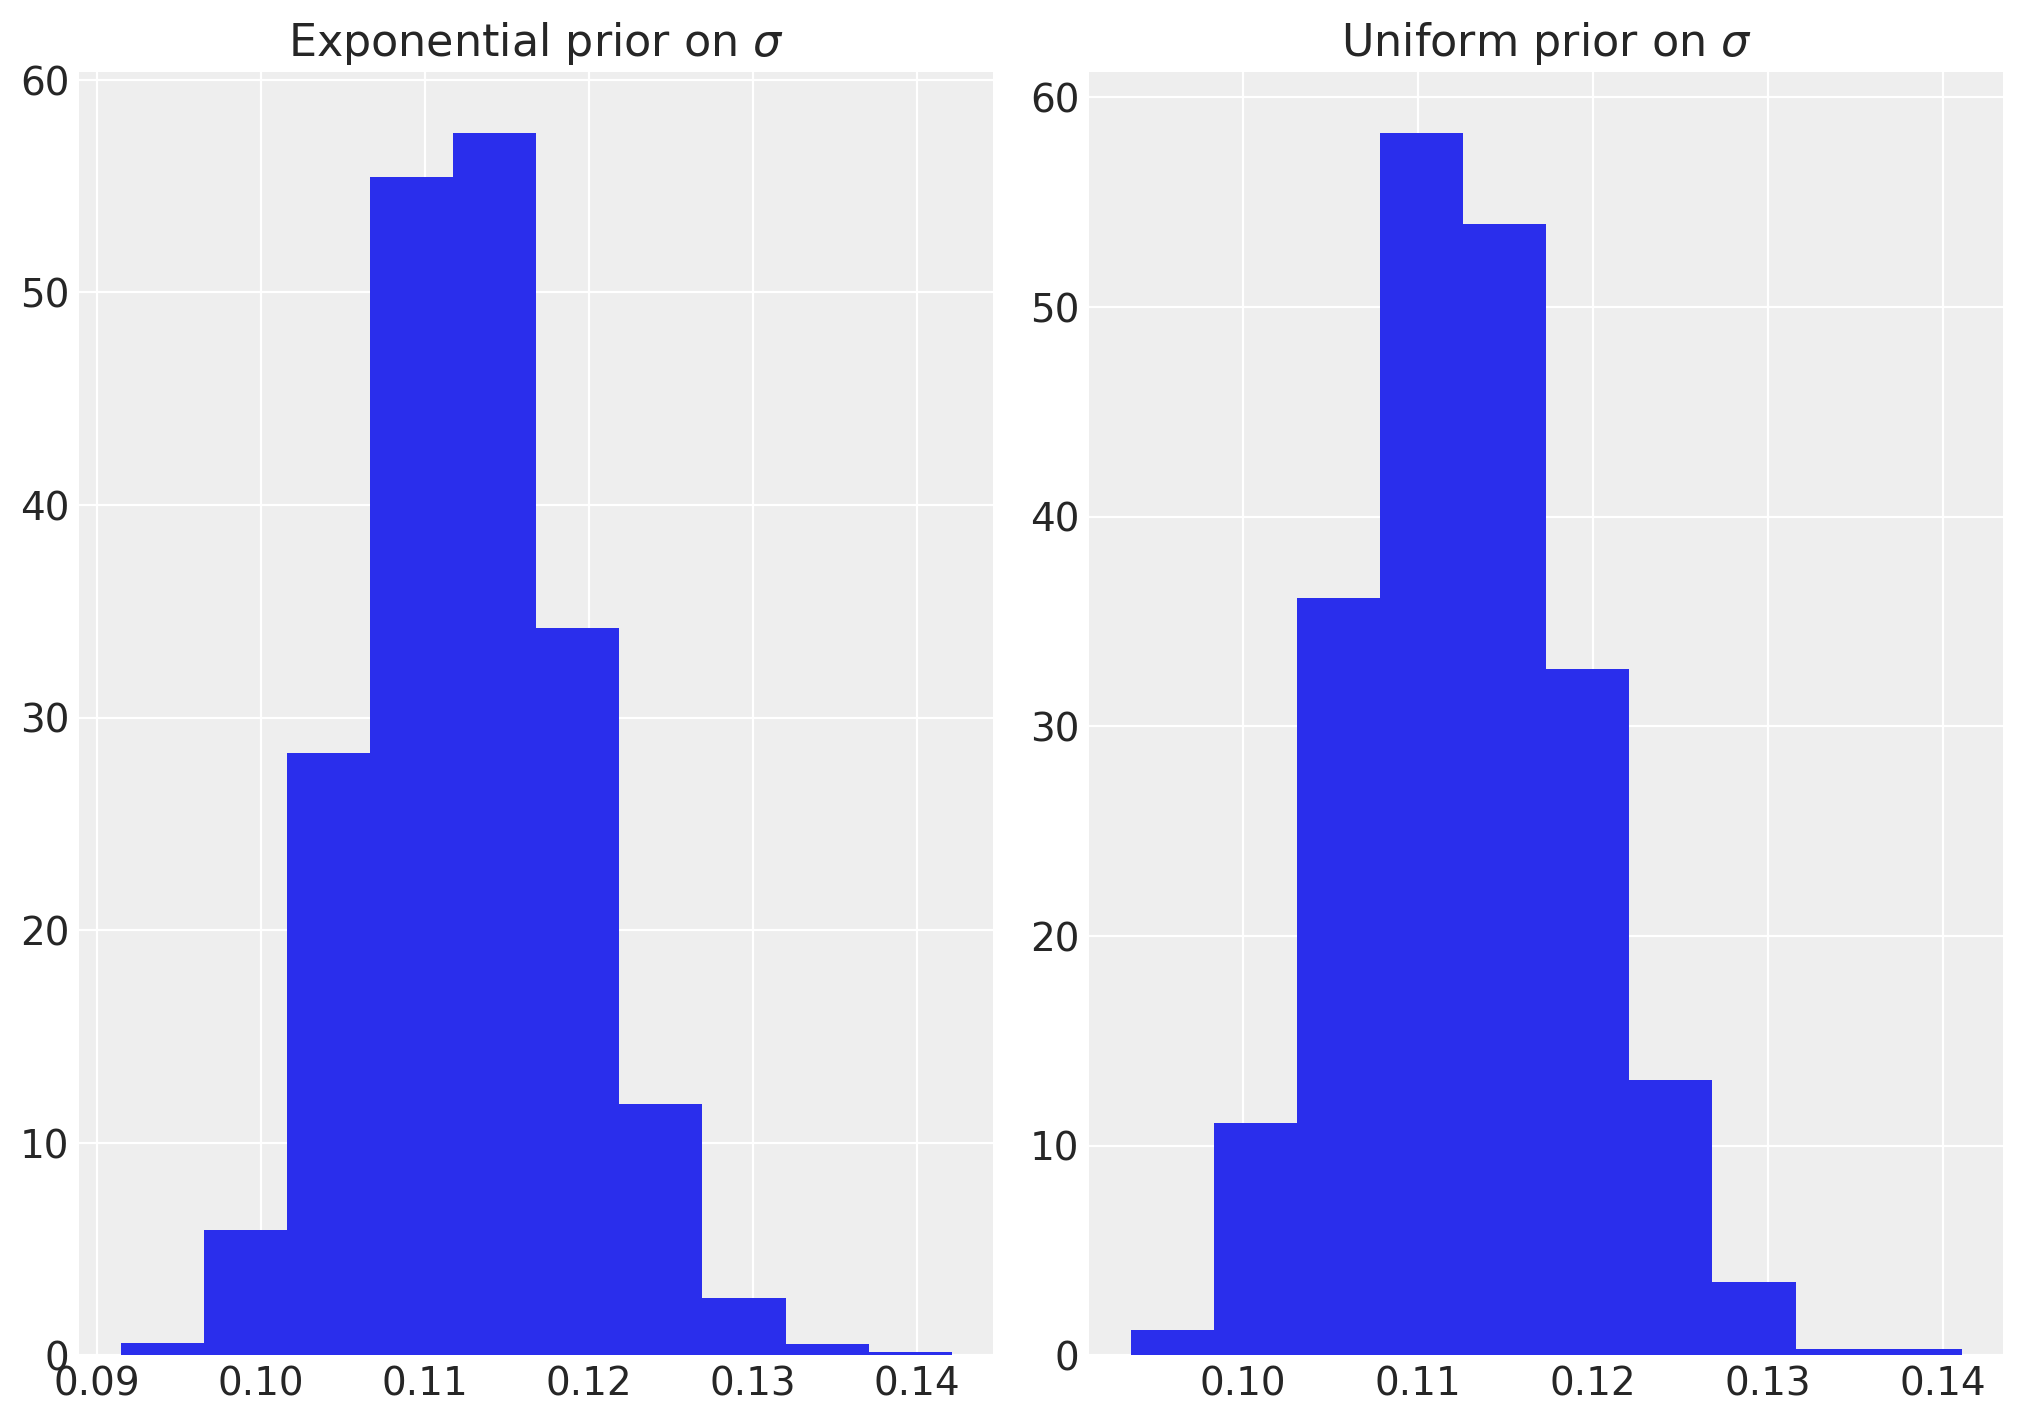

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

axs[0].hist(m8_3_sample["sigma"], density=True)
axs[0].set_title("Exponential prior on $\sigma$")

axs[1].hist(unif_sig_m8_3_sample["sigma"], density=True)
axs[1].set_title("Uniform prior on $\sigma$")

plt.show()

In [7]:
pm.summary(m8_3_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.021,1.059,0.000,0.000,6613.0,6600.0,6578.0,3164.0,1.0
a[1],0.861,0.017,0.831,0.893,0.000,0.000,6006.0,6006.0,6021.0,3082.0,1.0
b[0],-0.137,0.057,-0.245,-0.033,0.001,0.001,7475.0,6208.0,7490.0,2627.0,1.0
b[1],0.111,0.076,-0.037,0.249,0.001,0.001,7103.0,4971.0,7062.0,3249.0,1.0
sigma,0.113,0.006,0.100,0.124,0.000,0.000,5716.0,5645.0,5768.0,3329.0,1.0


In [8]:
pm.summary(unif_sig_m8_3_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.011,1.020,1.060,0.000,0.000,6540.0,6540.0,6541.0,3030.0,1.0
a[1],0.861,0.016,0.831,0.892,0.000,0.000,6814.0,6814.0,6806.0,3328.0,1.0
b[0],-0.138,0.058,-0.247,-0.034,0.001,0.001,6437.0,5541.0,6403.0,3524.0,1.0
b[1],0.112,0.079,-0.034,0.262,0.001,0.001,5837.0,3909.0,5825.0,3015.0,1.0
sigma,0.113,0.006,0.101,0.125,0.000,0.000,6535.0,6402.0,6676.0,3062.0,1.0


Switching the $\sigma$ prior from Exp(1) to Unif(0,1) really doesn't do a great deal to the model. We generally expect the model to choose a value less than one and this is what both of these priors anticapate, the exponential only partially (with 63% of it's mass for $\sigma \leq 1$ ), the uniform absolutely (With all of it's mass less than 1).

Moreover, there's a lot of data for us to use, and as both of these priors have similar enough qualitative expectations, the data drowns out any of the differences.

9M2. Modify the terrain ruggedness model again. This time, change the prior for b[cid] to dexp(0.3).
What does this do to the posterior distribution? Can you explain it?

Answer: I presume he means change the original model, and not to add this change in addition to the uniform that we did above (Not that I think this would actually do very much). Before we actually run it though, we now know this new prior constrains b to only having positive values. This should allow us to anticapate what's coming. Let's do it

In [9]:
with pm.Model() as b_exp_m8_3:
    a = pm.Normal("a", 0, 0.1, shape=2)
    b = pm.Exponential("b", 0.3, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = a[Complete.cont_africa] + b[Complete.cont_africa] * (
        Complete["s_rugged"] - 0.215
    )
    lgdp_std = pm.Normal("lgdp_std", mu=mu, sd=sigma, observed=Complete["s_log_gdp"])
    b_exp_m8_3_sample = pm.sample(draws=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


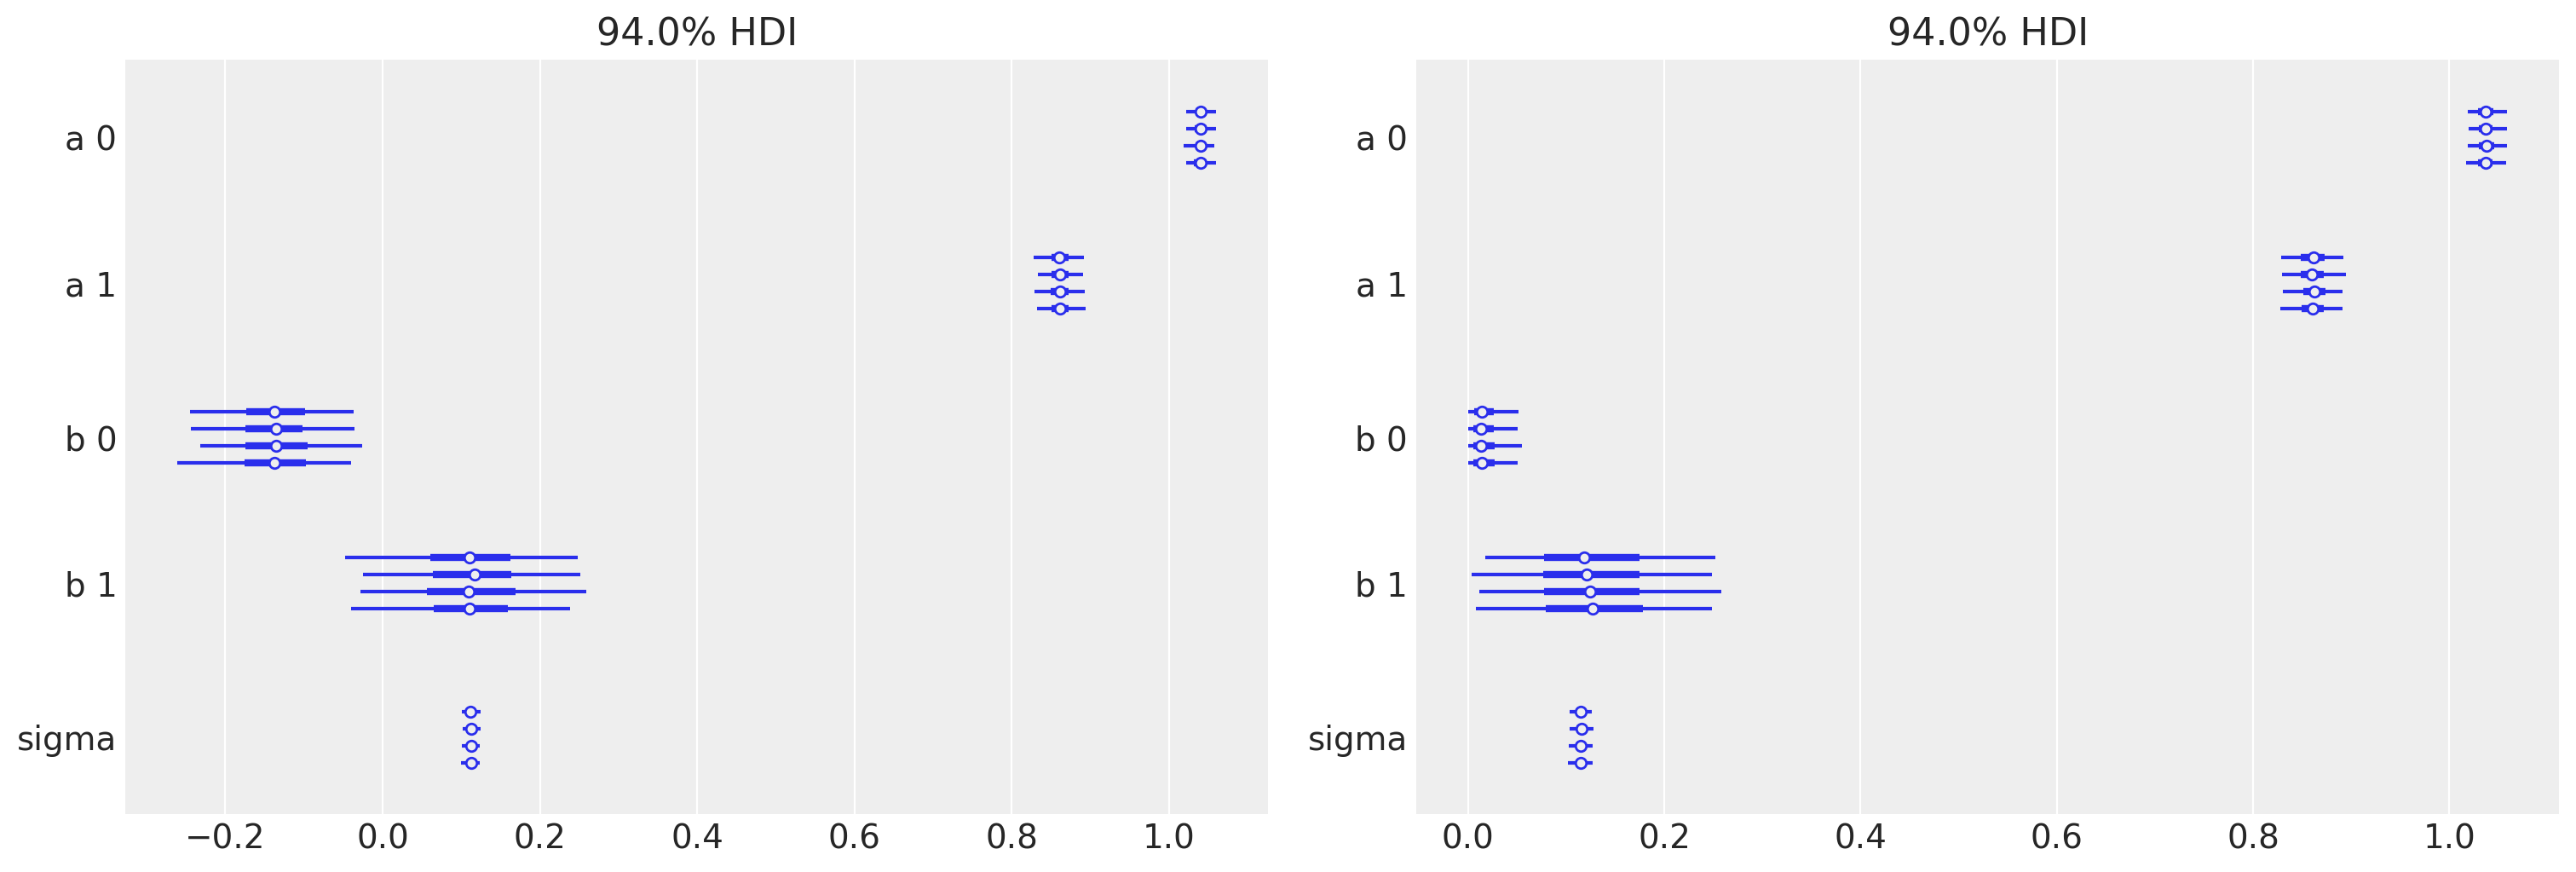

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


pm.forestplot(m8_3_sample, ax=axs[0])

pm.forestplot(b_exp_m8_3_sample, ax=axs[1])

plt.show()

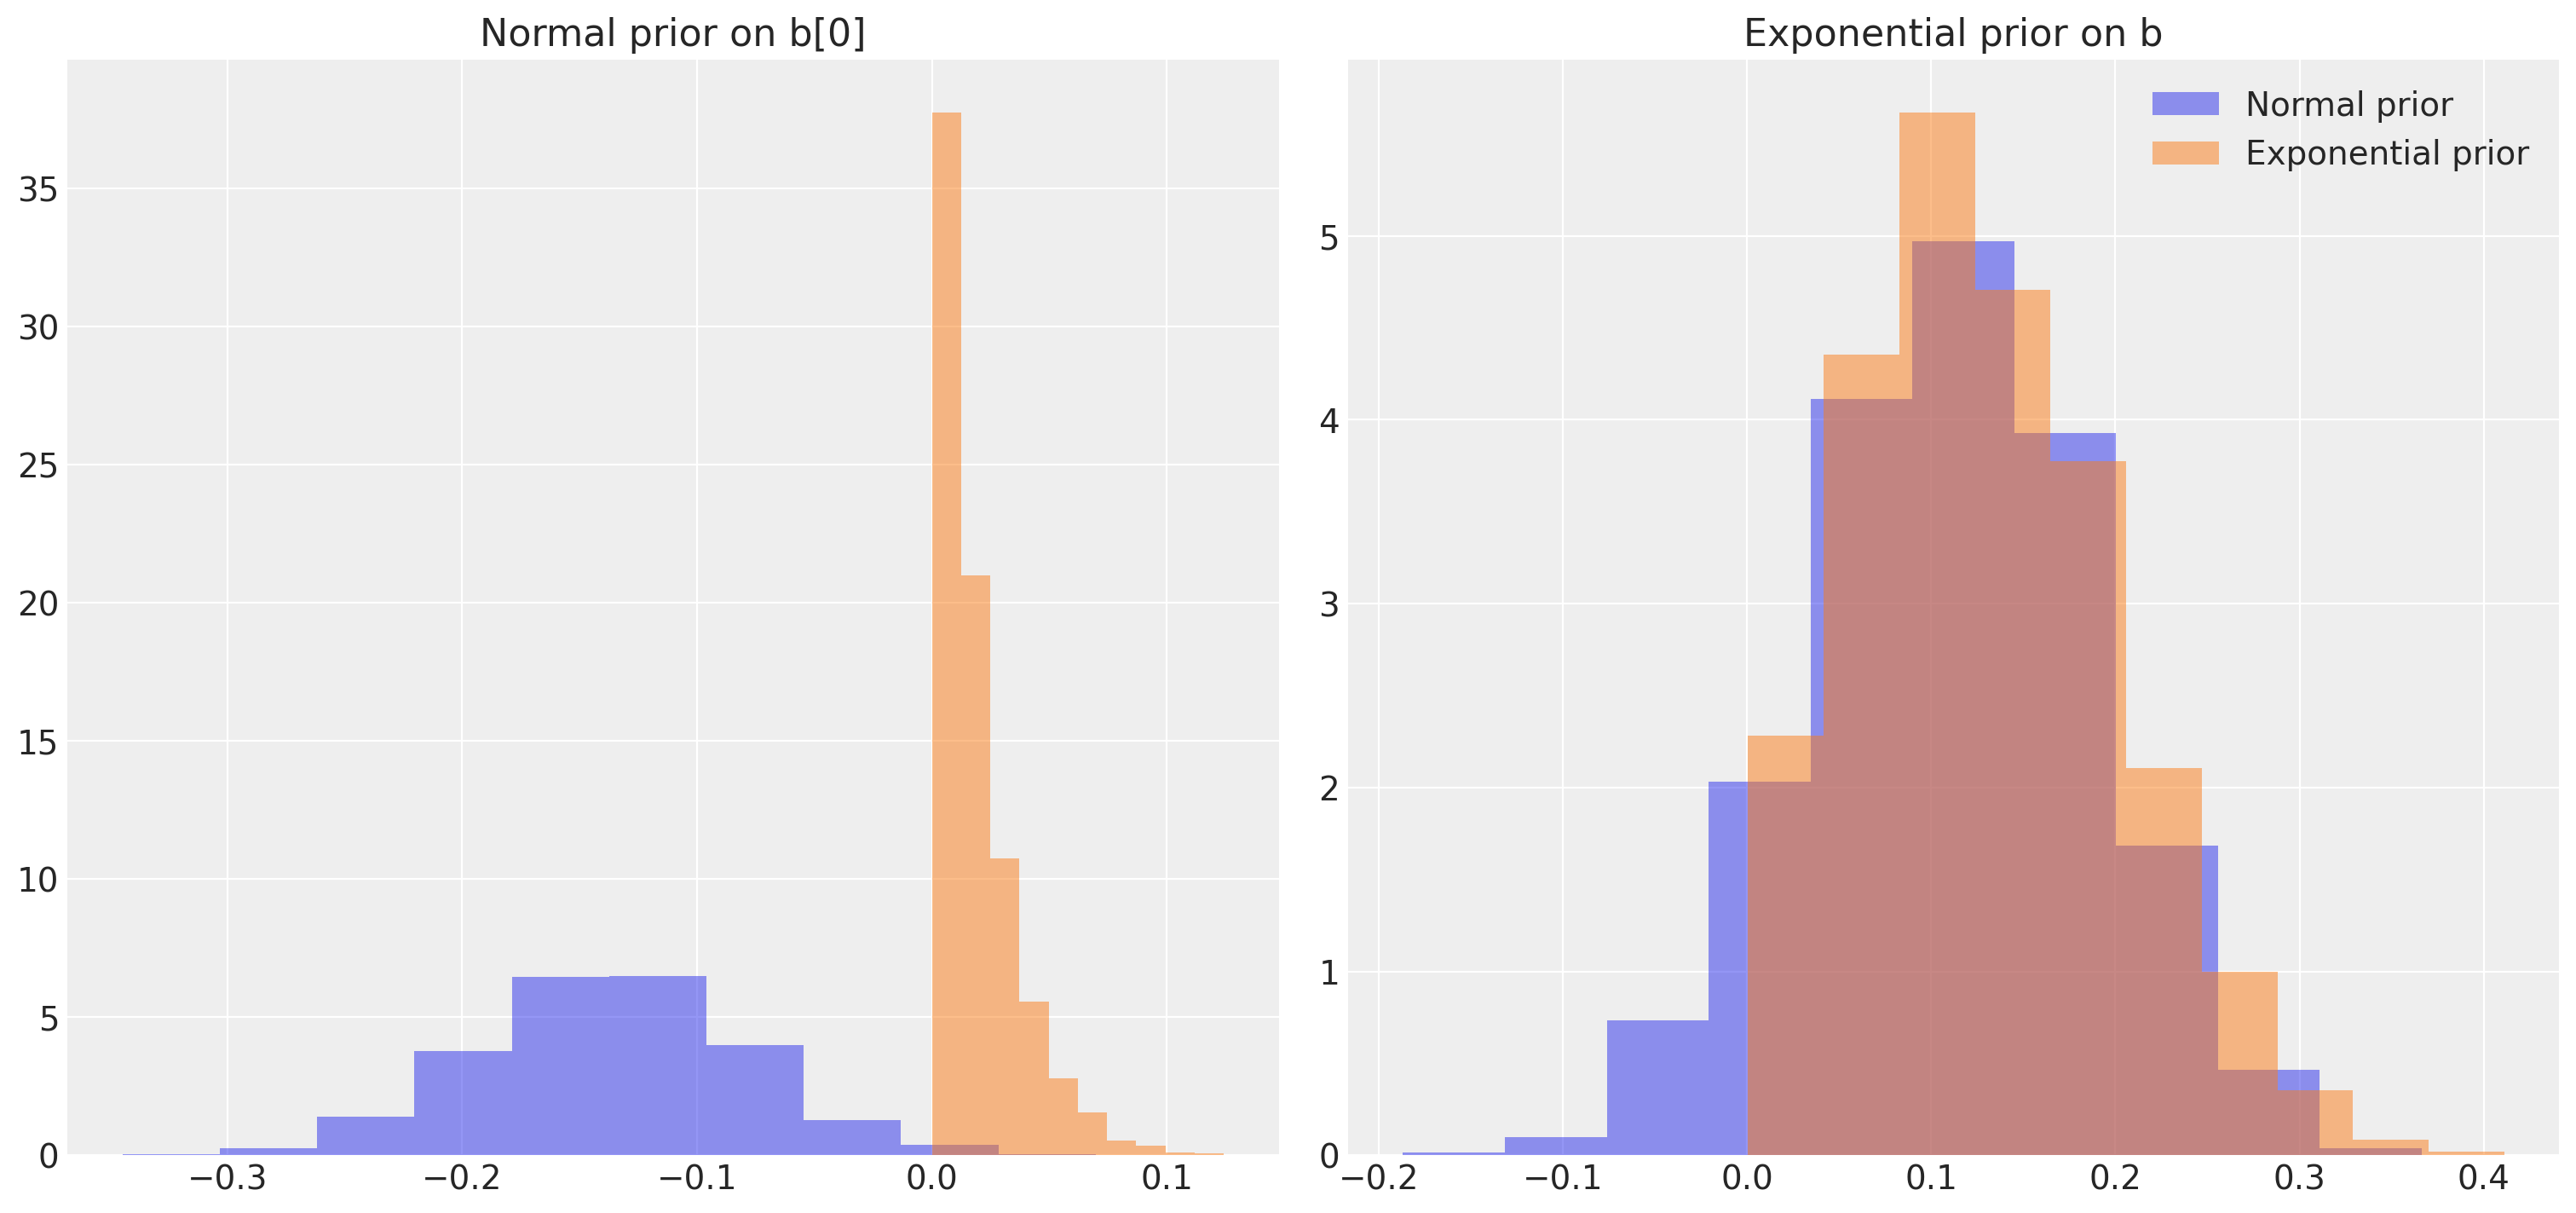

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].hist(m8_3_sample["b"][:, 0], density=True, alpha=0.5, label="Normal prior")
axs[0].hist(
    b_exp_m8_3_sample["b"][:, 0], density=True, alpha=0.5, label="Exponential prior"
)
axs[0].set_title("Normal prior on b[0]")

axs[1].hist(m8_3_sample["b"][:, 1], density=True, alpha=0.5, label="Normal prior")
axs[1].hist(
    b_exp_m8_3_sample["b"][:, 1], density=True, alpha=0.5, label="Exponential prior"
)
axs[1].set_title("Exponential prior on b")

plt.legend()
plt.show()

This simply constrains the parameters to be positive, as I stated above. Nothing else too spooky has occurs here that I can observe.

9M3. Re-estimate one of the Stan models from the chapter, but at different numbers of warmup iterations. Be sure to use the same number of sampling iterations in each case. Compare the n_eff
values. How much warmup is enough?

Answers: Alright then. We're using pymc3 and not stan, so we'll have to improvise.

To translate terms from the book into pymc3:

n_eff = ess_mean

Rhat4 = r_hat

(source: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb)

Basically, I think this is what the "tune" parameter is for when you use pymc3. See this guide for more info: https://colcarroll.github.io/hmc_tuning_talk/.

Let's draw random samples from the posterior a few times, each with different values for $\textit{tune}$ and see what happens

In [12]:
# get samples with different amounts of tuning
with m8_3:
    tune10 = pm.sample(draws=1000, chains=4, tune=10)
    tune100 = pm.sample(draws=1000, chains=4, tune=100)
    tune500 = pm.sample(draws=1000, chains=4, tune=500)
    tune1000 = pm.sample(draws=1000, chains=4, tune=1000)
    tune1500 = pm.sample(draws=1000, chains=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 10 tune and 1_000 draw iterations (40 + 4_000 draws total) took 5 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46983307788568107, but should be close to 0.8. Try to increase the number of tuning steps.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.024008994948713065, but should be close to 0.8. Try to increase the number of tuning steps.
There were 282 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29554772214259645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 330 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18192535482083746, but should be close to 

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9185926596934757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899043930486842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9178430366330885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9182307348789753, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 6 seconds.


As can be seen, some of the dramatic messages all now make sense. If you inspect the first run, we only had 100 tunning steps. This probably wasn't enough for the model to start running real well over all, and hence it couldn't get the step size right, which lead to a bad acceptance rate for the new samples, probably because the step size was set to a tiny tiny value. Once you reach around 500 tuning samples however, the system is able figure out a good step size allowing it to sample much much more effectively.

In [13]:
pm.summary(tune10)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.039,0.010,1.022,1.057,0.001,0.000,299.0,299.0,300.0,297.0,1.03
a[1],0.857,0.019,0.831,0.899,0.003,0.002,48.0,48.0,45.0,126.0,1.07
b[0],-0.106,0.066,-0.233,-0.017,0.013,0.010,25.0,25.0,24.0,172.0,1.12
b[1],0.099,0.099,-0.078,0.310,0.017,0.012,34.0,34.0,34.0,25.0,1.05
sigma,0.117,0.012,0.101,0.133,0.003,0.002,14.0,14.0,14.0,76.0,1.21


For the model with ten, the numbe of effect sample is tiny. If you look at the warning message you can see that the acceptance rate swings around erratically for each of the four chains, some near 0, some near 1, but all off the pre-decided target acceptance rate of 0.8. (I don't know why 0.8 is the magic number)

In [14]:
pm.summary(tune100)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.020,1.059,0.000,0.000,4612.0,4608.0,4606.0,3023.0,1.0
a[1],0.861,0.016,0.829,0.890,0.000,0.000,4575.0,4572.0,4571.0,3276.0,1.0
b[0],-0.139,0.057,-0.248,-0.033,0.001,0.001,1694.0,1637.0,1691.0,1854.0,1.0
b[1],0.111,0.079,-0.038,0.258,0.002,0.002,1354.0,1339.0,1357.0,1629.0,1.0
sigma,0.113,0.006,0.101,0.125,0.000,0.000,3214.0,3193.0,3225.0,2264.0,1.0


Increasing the tuning samples makes the number of effective samples for a, and sigma much better, nearer to the actual number of samples of 4000. But the numbers for b are still offensively small in comparison. I'm not totally sure why there are so many more effective samples for parameter a than parameter b. Given that they have a broader prior than a, I'd have thought there would be less of an issue for sampling well.

# Have a better reason for why this happens

In [15]:
pm.summary(tune500)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.020,1.059,0.000,0.000,5980.0,5980.0,5963.0,3450.0,1.0
a[1],0.861,0.016,0.831,0.891,0.000,0.000,5174.0,5174.0,5177.0,3588.0,1.0
b[0],-0.138,0.057,-0.247,-0.032,0.001,0.001,5905.0,5040.0,5906.0,3191.0,1.0
b[1],0.111,0.076,-0.029,0.259,0.001,0.001,5770.0,4457.0,5764.0,3334.0,1.0
sigma,0.112,0.006,0.101,0.124,0.000,0.000,4632.0,4628.0,4611.0,3059.0,1.0


In [16]:
pm.summary(tune1000)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.020,1.059,0.000,0.000,6193.0,6193.0,6199.0,3208.0,1.0
a[1],0.861,0.016,0.832,0.893,0.000,0.000,5735.0,5735.0,5738.0,3247.0,1.0
b[0],-0.138,0.057,-0.248,-0.032,0.001,0.001,6112.0,4906.0,6129.0,2829.0,1.0
b[1],0.113,0.075,-0.025,0.257,0.001,0.001,5638.0,4387.0,5647.0,3377.0,1.0
sigma,0.113,0.006,0.101,0.124,0.000,0.000,5660.0,5611.0,5684.0,2912.0,1.0


In [17]:
pm.summary(tune1500)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.040,0.010,1.020,1.058,0.000,0.000,6104.0,6104.0,6081.0,2747.0,1.0
a[1],0.861,0.017,0.827,0.891,0.000,0.000,6348.0,6348.0,6357.0,3364.0,1.0
b[0],-0.138,0.057,-0.245,-0.030,0.001,0.001,6334.0,5098.0,6297.0,3207.0,1.0
b[1],0.113,0.076,-0.029,0.250,0.001,0.001,7563.0,5257.0,7549.0,3426.0,1.0
sigma,0.113,0.006,0.101,0.125,0.000,0.000,6315.0,6302.0,6288.0,3480.0,1.0


We can see that after 500 tuning steps, the growth in the effective number of samples stops growing as rapidly, and that all are higher than the actual 4,000 samples that were actually done.

9H1. Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

mp <- ulam(

alist(

a ~ dnorm(0,1),

b ~ dcauchy(0,1)

), data=list(y=1) , chains=1 )

Compare the samples for the parameters a and b. Can you explain the different trace plots? If you are
unfamiliar with the Cauchy distribution, you should look it up. The key feature to attend to is that it
has no expected value. Can you connect this fact to the trace plot?

Answer: This is a strange model. There's no likelihood model written into this. I'm not even sure you can write this in pymc3. The model doesn't make any connection between a,b and the data. It just specifies the priors. I think this model basically just samples the prior distributions, and the purpose of the question is to see how well MCMC can handle the two prior distributions. As we all know Cauchy distributions are fat tailed and the central limit theorems break down for these models, so we expect everything to go bonkers with the samples.

In [18]:
# run the model from question H1

with pm.Model() as H1:
    a = pm.Normal("a", 0, 0.1)
    b = pm.Cauchy("b", 0, 1)
    y = 1
    prior_sample = pm.sample_prior_predictive(samples=1000)
    H1_post_sample = pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [b, a]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

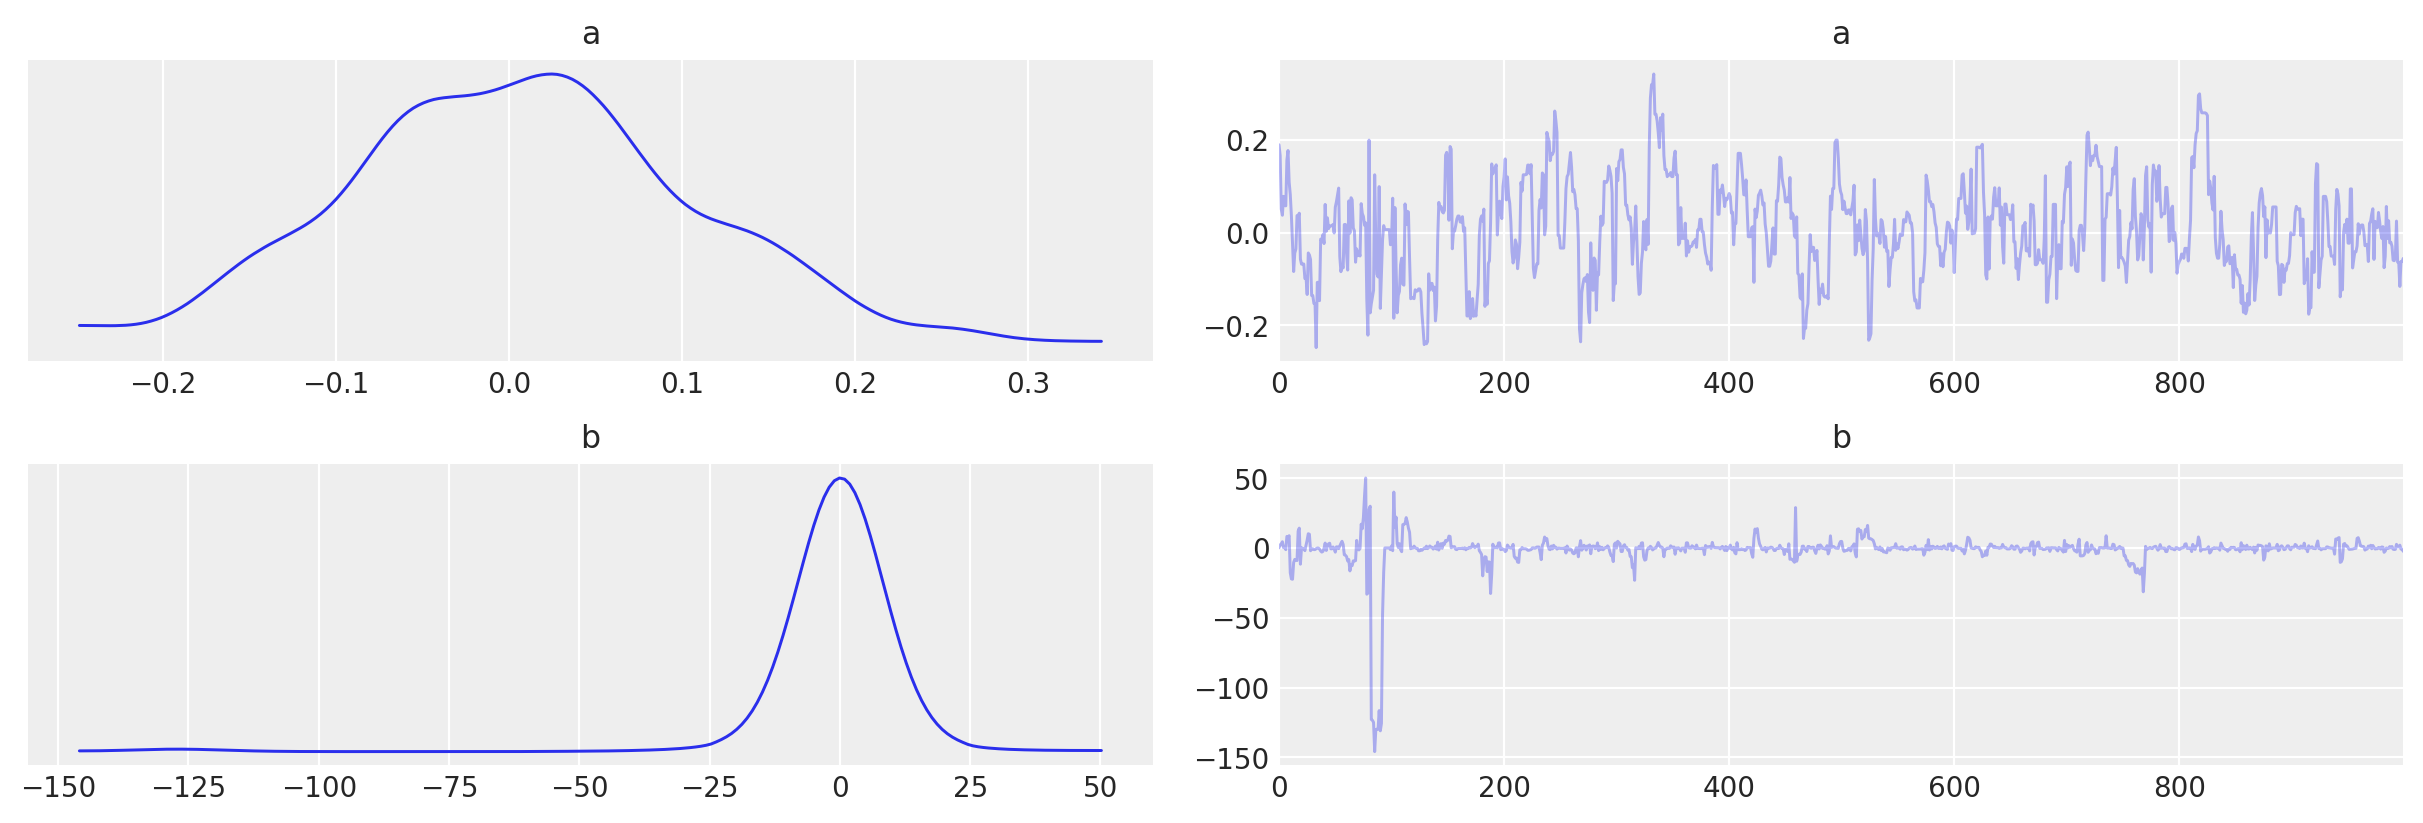

In [19]:
pm.traceplot(H1_post_sample)

Indeed, the trace plot goes go bonkers for b, as we periodically get wild values. It breaks the stationarity criterion of a "healthy" chain. This all boils down to the Cauchy distribition being heavy tailed, so extreme outliers aren't too uncommon for this sample. Looking at parameter a, we see that the chain remains firmly located within a tiny narrow range of the sample space, as it should for a well behaving normal distribution.

9H2. Recall the divorce rate example from Chapter 5. Repeat that analysis, using ulam this time,
fitting models m5.1, m5.2, and m5.3. Use compare to compare the models on the basis of WAIC
or PSIS. To use WAIC or PSIS with ulam, you need add the argument log_log=TRUE. Explain the
model comparison results.

Answer: So MCMC was what I was using all along (and that's more than okay). But now I've got to add the model comparison to the part to the code. This is straightforward in pymc3. We'll use PSIS to perform our model comparison.

In [20]:
# yoink the data
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")  # load waffle data

In [21]:
# scale all of the data
scaled_M = (data.Marriage - np.mean(data.Marriage)) / np.std(data.Marriage)
scaled_A = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage)) / np.std(
    data.MedianAgeMarriage
)
scaled_D = (data.Divorce - np.mean(data.Divorce)) / np.std(data.Divorce)

One can peform linear regressions. I reproduce fig 5.2 showing the Bayesian linear regressions between Marriage rate and divorce rate asa well as Median Marriage age and divorce rate

In [22]:
# running a Age_divorce linear regression
with pm.Model() as m5_1:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_A", mu=0, sd=0.5)  # prior on beta
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta * scaled_A
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_1_sample = pm.sample(draws=250, chains=4)


with pm.Model() as m5_2:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta * scaled_M
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_2_sample = pm.sample(draws=250, chains=4)


with pm.Model() as m5_3:
    alpha = pm.Normal("alpha", mu=0, sd=0.2)  # prior on alpha
    beta = pm.Normal("beta_M", mu=0, sd=0.5, shape=2)  # prior on beta terms
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta[0] * scaled_A + beta[1] * scaled_M
    Divorce = pm.Normal(
        "Divorce", mu=mu, sd=sigma, observed=scaled_D
    )  # likelihood of the data
    # 1000 random samples on 4 chains
    m5_3_sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 4 seconds.


In [23]:
az.compare(
    {"m5_1": m5_1_sample, "m5_2": m5_2_sample, "m5_3": m5_3_sample}, scale="deviance"
)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_1,0,126.712,3.63957,0,0.65421,11.8659,0,False,deviance
m5_3,1,128.445,4.62548,1.73261,0.274413,9.33872,0.794653,False,deviance
m5_2,2,140.265,2.94204,13.5532,0.0713764,11.677,9.29676,False,deviance


We can see that k>0.7 for one of the models in the system. This is probably due to some outliers within the data.

It can be seen that model 5.1 and 5.3 perform similarly in making predictions out of sample. Model 5.2 does much worse than the other two with a much larger deviance. Models 5.1 and 5.3 both include the age of the participants, but m5.3 also includes the Marriage rate. m5.2 performs much worse than the other two models and just uses age. This overall picture indicates that Marriage isn't a particalarly predictive variable, without making any reference to the causal structure of the model.

9H3. Sometimes changing a prior for one parameter has unanticipated effects on other parameters.
This is because when a parameter is highly correlated with another parameter in the posterior, the
prior influences both parameters. Here’s an example to work and think through.

Go back to the leg length example in Chapter 6 and use the code there to simulate height and
leg lengths for 100 imagined individuals. Below is the model you fit before, resulting in a highly
correlated posterior for the two beta parameters. This time, fit the model using ulam:

m5.8s <- ulam(

alist(

height ~ dnorm( mu , sigma ) ,

mu <- a + bl*leg_left + br*leg_right ,

a ~ dnorm( 10 , 100 ) ,

bl ~ dnorm( 2 , 10 ) ,

br ~ dnorm( 2 , 10 ) ,

sigma ~ dexp( 1 )

) , data=d, chains=4,

start=list(a=10,bl=0,br=0.1,sigma=1) )

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for br so that it is strictly positive:


m5.8s2 <- ulam(

alist(

height ~ dnorm( mu , sigma ) ,

mu <- a + bl*leg_left + br*leg_right ,

a ~ dnorm( 10 , 100 ) ,

bl ~ dnorm( 2 , 10 ) ,

br ~ dnorm( 2 , 10 ) ,

sigma ~ dexp( 1 )

) , data=d, chains=4,

constraints=list(br="lower=0"),

start=list(a=10,bl=0,br=0.1,sigma=1) )

Note the constraints list. What this does is constrain the prior distribution of br so that it has
positive probability only above zero. In other words, that prior ensures that the posterior distribution
for br will have no probability mass below zero. Compare the two posterior distributions for m5.8s
and m5.8s2. What has changed in the posterior distribution of both beta parameters? Can you
explain the change induced by the change in prior?

Answer: First is the code to resimulate the leg data. I copied this code from (https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb) I don't want to reinvent the wheel here.

Additionally, I believe that this (https://docs.pymc.io/api/bounds.html) is the way to incorporate the "constraints" that McElreaths Rethinking package uses. They're called bounds in pymc3.

We can also incorporate the start point of the sampler by just setting the start value inside pm.sample.

In order for the sampler to actually work well though, I had to really up the sampling level for the bounded model. I'm not totally sure what's causing it to get so buggy. Something about bounding removing the normalisastion could be the culprit

Let's go!

In [24]:
# Stolen code for producing the simulated leg length data

N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(
    0, 0.02, N
)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,6.847164,3.075836,3.057583
1,11.188234,4.535465,4.541233
2,8.976602,3.945780,3.983261
3,9.908043,4.221646,4.227552
4,6.931174,3.038713,3.087786


In [25]:
# run the basic model

# define the sampling start point
start = {"a": 10, "bl": 0, "br": 0.1, "sigma": 1}

with pm.Model() as m5_8s:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)
    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    m5_8s_sample = pm.sample()


# run the constrained model

with pm.Model() as m5_8s2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    # introduce a function for bounding br parameter
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    br = BoundedNormal("br", 2, 10)
    mu = a + bl * d.leg_left + br * d.leg_right
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height)
    m5_8s2_sample = pm.sample(draws=3000, chains=4, tune=2000, start=start)
    idata_m5_8s2 = az.from_pymc3(
        m5_8s2_sample
    )  # create an arviz InferenceData object from the trace.
    # this happens automatically when calling az.summary, but as we'll be using this trace multiple
    # times below it's more efficient to do the conversion once at the start.

INFO (theano.gof.compilelock): Waiting for existing lock by process '15943' (I am process '16003')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '15943' (I am process '16003')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 166 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
INFO (theano.gof.compilelock): Waiting for existing lock by process '15241' (I am process '16003')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 80 seconds.
There were 807 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4536922321907167, but should be close to 0.8. Try to increase the number of tuning steps.
There were 618 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5737772224057891, but should be close to 0.8. Try to increase the number of tuning steps.
There were 955 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4081323869582942, but should be close to 0.8. Try to increase the number of tuning steps.
There were 805 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4304280209190004, but should be close

In [26]:
pm.summary(m5_8s_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.145,0.316,0.515,1.723,0.008,0.006,1601.0,1601.0,1630.0,1479.0,1.0
bl,0.644,1.953,-2.997,4.246,0.056,0.042,1205.0,1103.0,1225.0,1424.0,1.0
br,1.343,1.942,-2.431,4.832,0.056,0.040,1199.0,1199.0,1220.0,1427.0,1.0
sigma,0.631,0.043,0.557,0.709,0.001,0.001,1303.0,1303.0,1248.0,1106.0,1.0


In [27]:
pm.summary(m5_8s2_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.175,0.273,0.685,1.696,0.044,0.034,39.0,34.0,40.0,59.0,1.07
bl,1.727,0.152,1.474,1.986,0.029,0.021,28.0,28.0,26.0,31.0,1.11
br,0.256,0.140,0.000,0.485,0.029,0.024,24.0,17.0,24.0,20.0,1.11
sigma,0.624,0.042,0.556,0.706,0.007,0.005,41.0,41.0,36.0,167.0,1.08


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


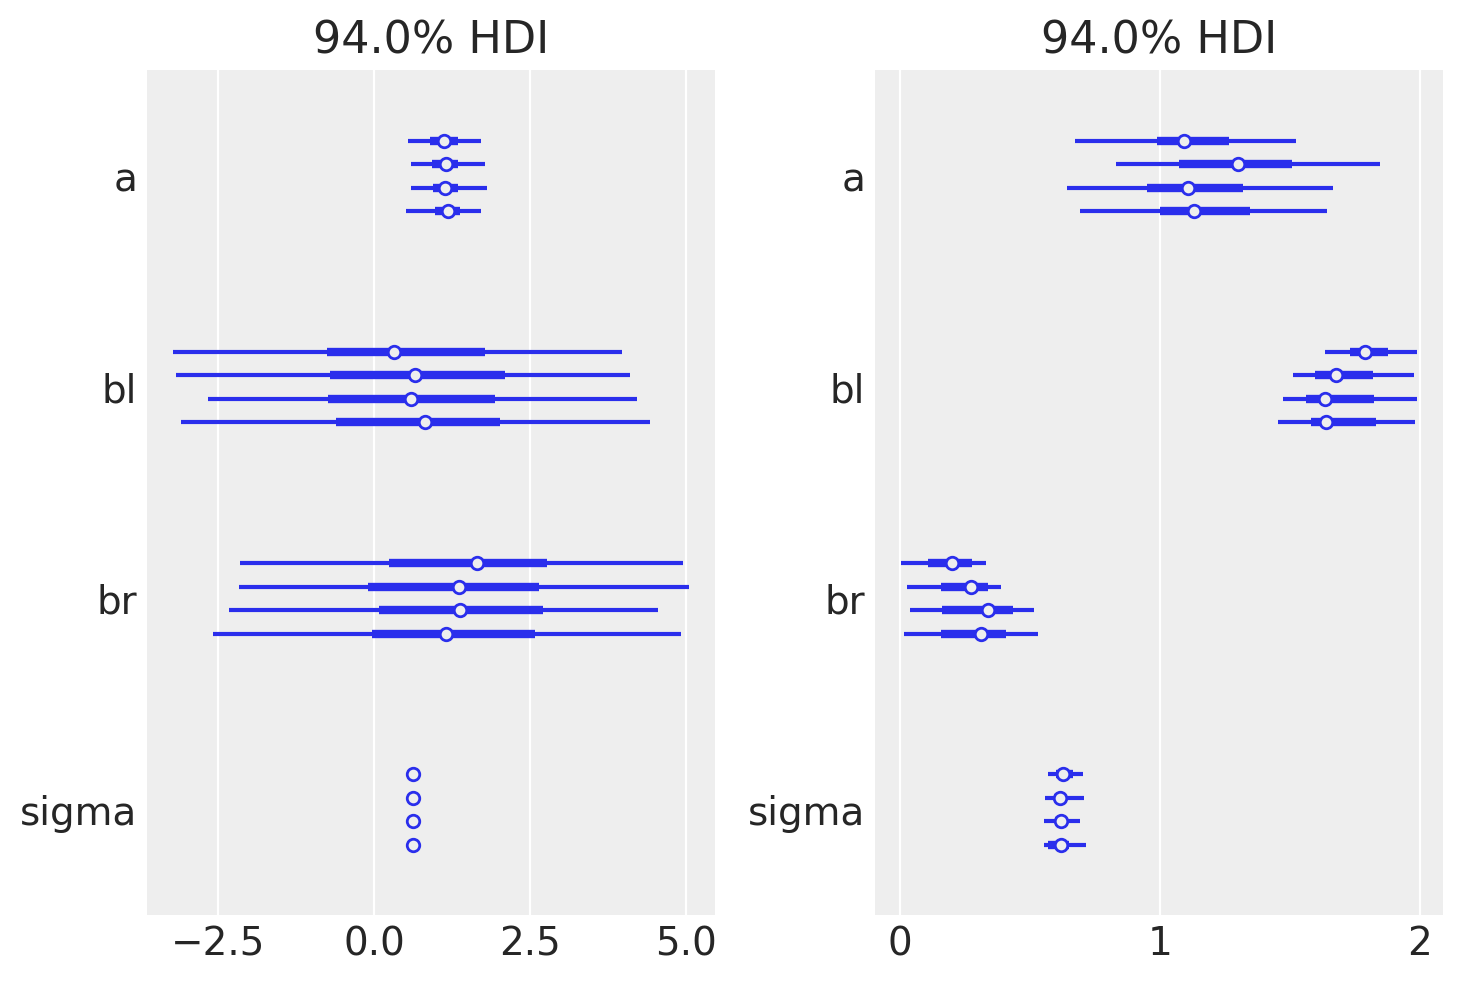

In [28]:
fig, axs = plt.subplots(1, 2)
pm.forestplot(m5_8s_sample, ax=axs[0])
pm.forestplot(m5_8s2_sample, ax=axs[1])
plt.show()

Obviously bounding the prior in this way constrains br to be positive. More interesting will be to observe it's impact on the correlation between pairs of parameters in the two models.

In [29]:
with m5_8s:
    test_sample = pm.sample(draws=500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, br, bl, a]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 105 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8870627323587222, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
pm.summary(test_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.173,0.303,0.601,1.750,0.012,0.009,647.0,610.0,653.0,547.0,1.00
bl,0.707,1.983,-3.242,4.307,0.105,0.085,355.0,270.0,357.0,250.0,1.01
br,1.275,1.975,-2.364,5.149,0.105,0.074,355.0,355.0,359.0,247.0,1.01
sigma,0.629,0.046,0.551,0.715,0.002,0.002,458.0,450.0,478.0,457.0,1.00


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='bl'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='br'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a', ylabel='sigma'>,
        <AxesSubplot:xlabel='bl'>, <AxesSubplot:xlabel='br'>]],
      dtype=object)

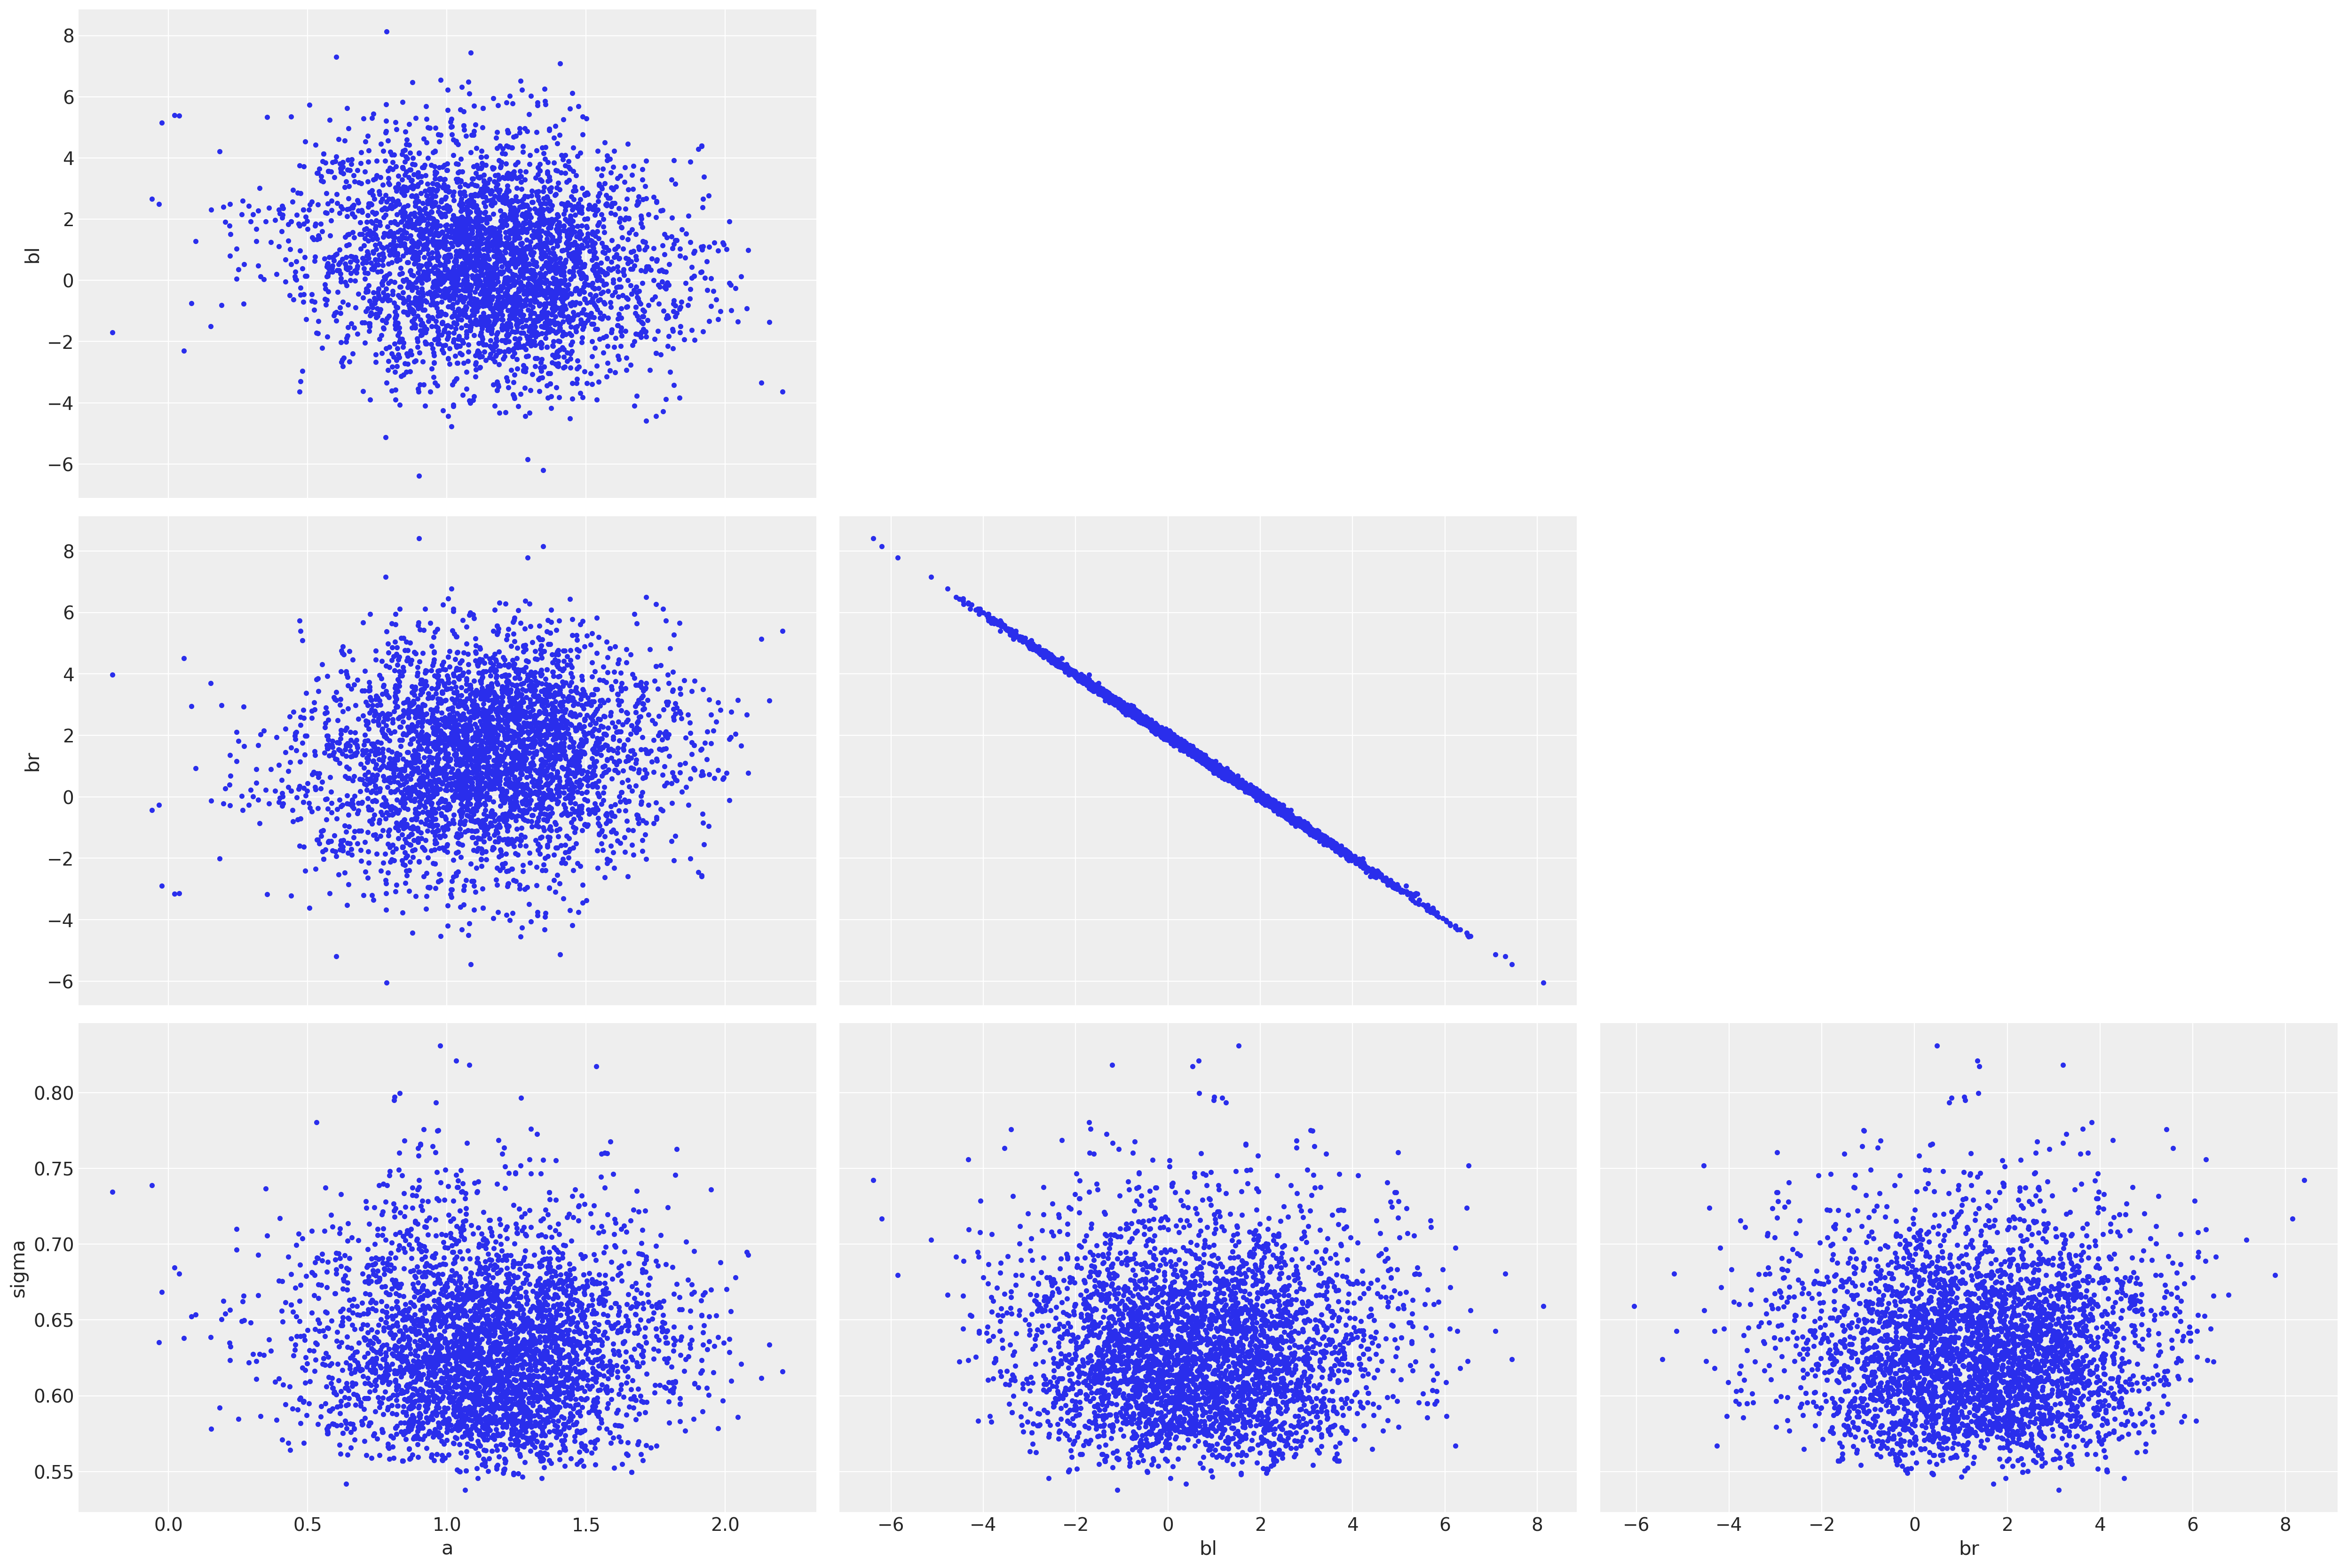

In [31]:
pm.pairplot(m5_8s_sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='bl'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='br'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a', ylabel='sigma'>,
        <AxesSubplot:xlabel='bl'>, <AxesSubplot:xlabel='br'>]],
      dtype=object)

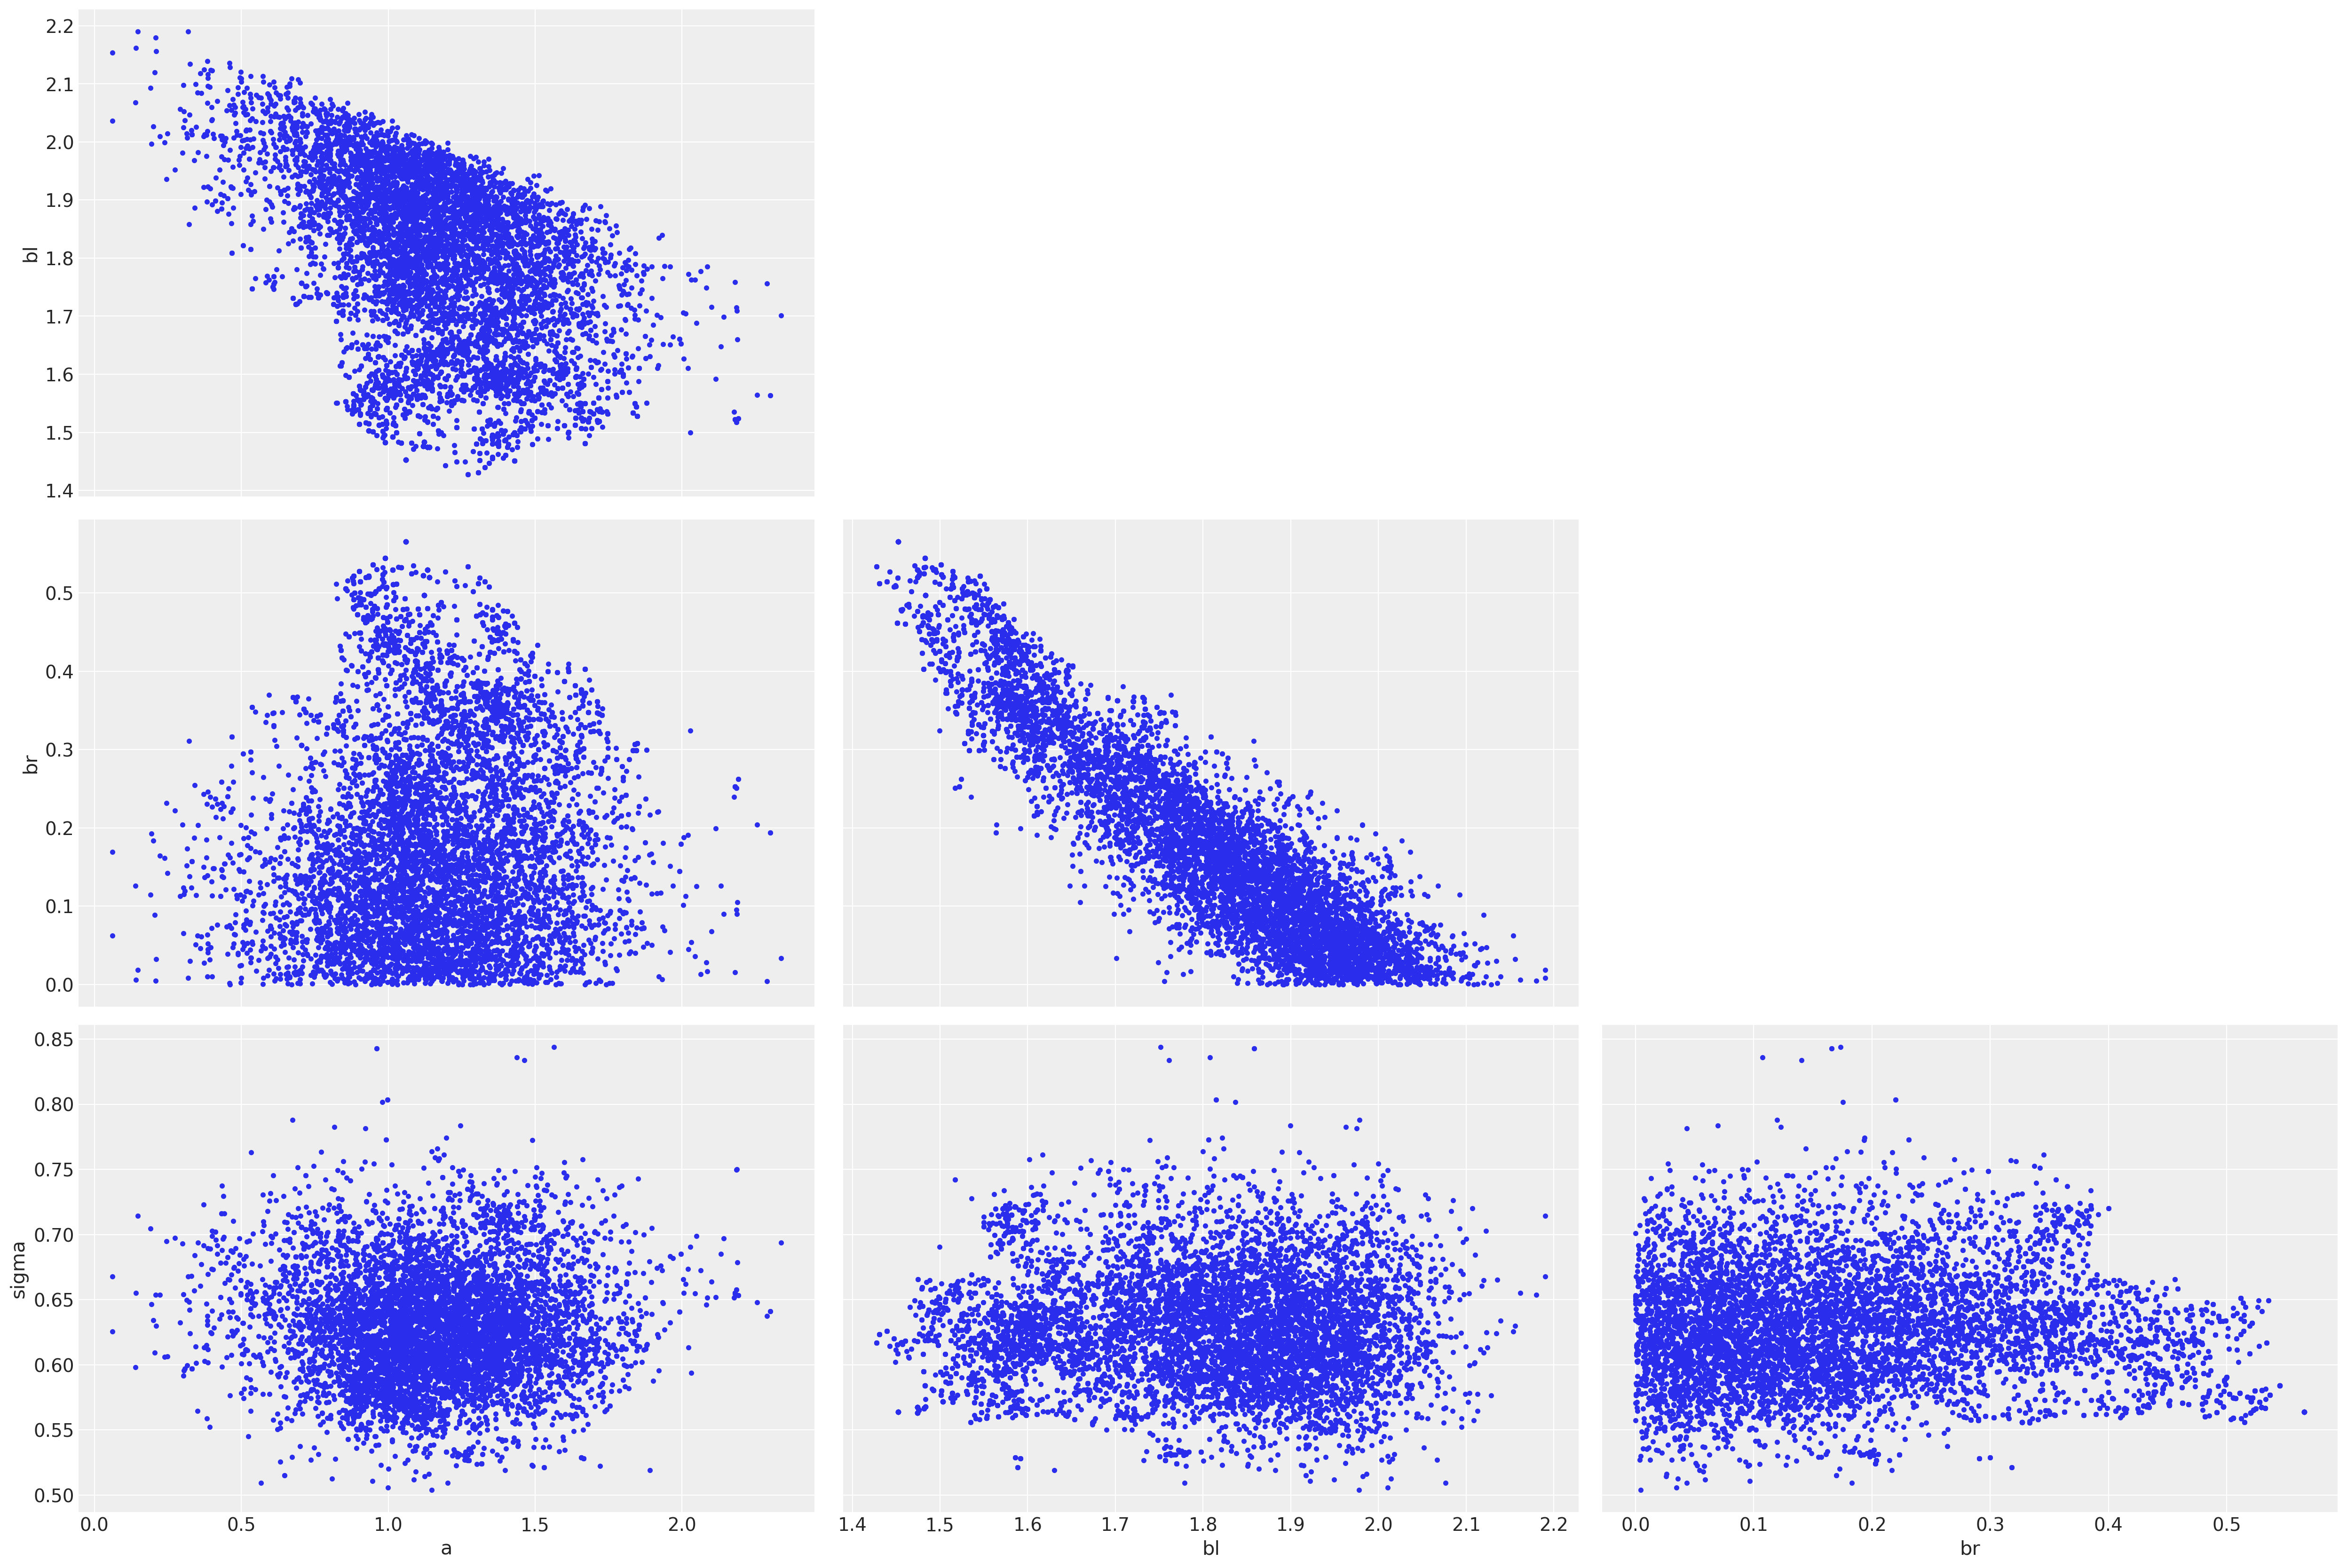

In [32]:
pm.pairplot(m5_8s2_sample)

These look truly hideous for the second model. I think the sample didn't work very well here because of the many many divergences that took place during the sampling process. The number of effective samples is also

9H4. For the two models fit in the previous problem, use WAIC or PSIS to compare the effective
numbers of parameters for each model. You will need to use log_lik=TRUE to instruct ulam to
compute the terms that both WAIC and PSIS need. Which model has more effective parameters?
Why?


In [33]:
az.compare({"m5_8s": m5_8s_sample, "m5_8s2": m5_8s2_sample}, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m5_8s2,0,191.175,2.14739,0,0.733431,11.3769,0,False,deviance
m5_8s,1,193.388,3.27412,2.21269,0.266569,11.6513,1.1291,False,deviance


The second model performed considerably worse than the first one at out of sample prediction. Assuming this wasn't caused by the sampling issues (which is possibly a terrible assumption), my intuitive understanding is that this is caused by the forcing one of the parameters to be positive against its will.

# Have a better explanation of why this happens

In [34]:
%watermark -n -u -v -iv -w

Last updated: Fri Dec 11 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.1
pandas    : 1.1.3
pymc3     : 3.9.3
arviz     : 0.9.0
matplotlib: 3.3.2

Watermark: 2.1.0

